<a href="https://colab.research.google.com/github/gangakailas/Image_and_Video_Processing-Lab/blob/main/Set_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

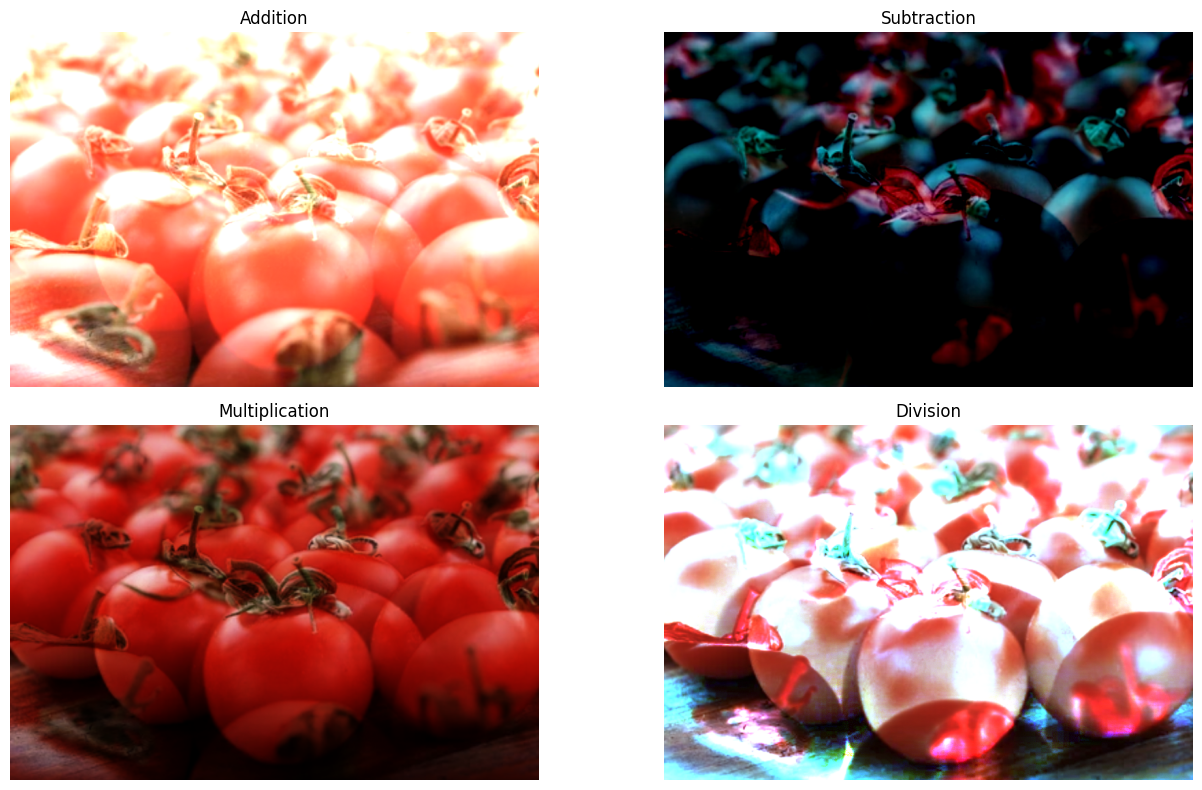

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load two new images from Google Drive
image1_path = '/content/drive/MyDrive/img1.png'  # ✅ update path
image2_path = '/content/drive/MyDrive/img2.png'  # ✅ update path

img1 = Image.open(image1_path).convert('RGB')
img2 = Image.open(image2_path).convert('RGB')

# Resize both to the same size (use img1 size)
img2 = img2.resize(img1.size)

# Convert to NumPy arrays
img1_np = np.array(img1).astype(np.float32)
img2_np = np.array(img2).astype(np.float32)

# Perform arithmetic operations
added = np.clip(img1_np + img2_np, 0, 255).astype(np.uint8)
subtracted = np.clip(img1_np - img2_np, 0, 255).astype(np.uint8)
multiplied = np.clip((img1_np * img2_np) / 255, 0, 255).astype(np.uint8)
divided = np.clip((img1_np / (img2_np + 1e-5)) * 255, 0, 255).astype(np.uint8)

# Plot all results
titles = ['Addition', 'Subtraction', 'Multiplication', 'Division']
images = [added, subtracted, multiplied, divided]

plt.figure(figsize=(14, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Averaging Level  | MSE        | PSNR (dB) 
---------------------------------------------
2                | 287.90     | 23.54     
8                | 74.21      | 29.43     
16               | 38.36      | 32.29     
32               | 20.45      | 35.02     
128              | 7.15       | 39.59     


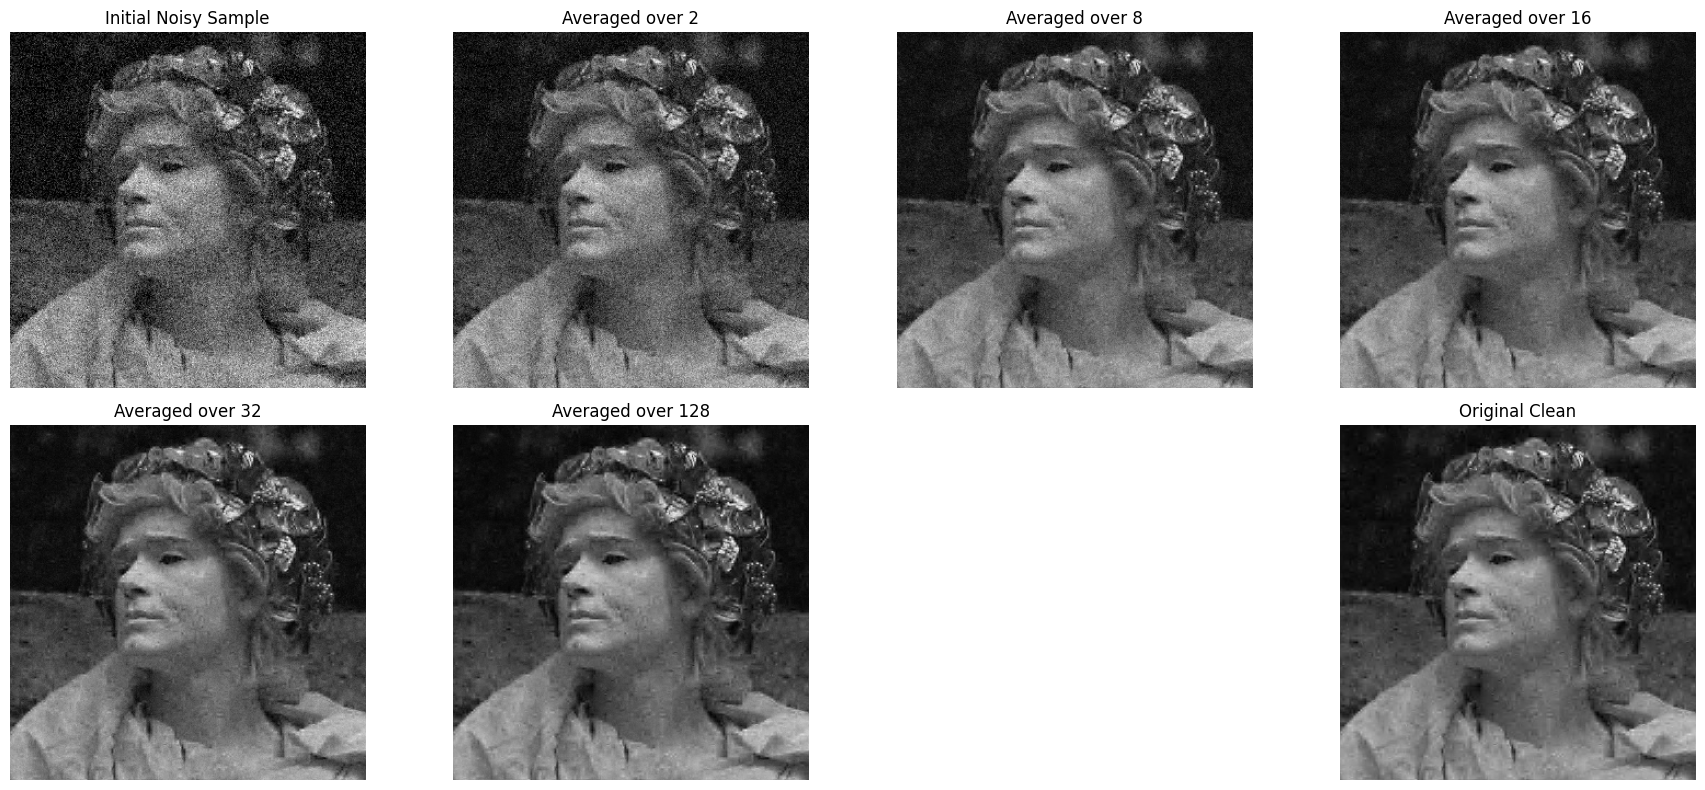

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


noisy_img = cv2.imread('/content/drive/MyDrive/noisy_img.jpg')  # Replace with your image path
noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
clean_img = cv2.imread('/content/drive/MyDrive/clean_img.jpg', cv2.IMREAD_GRAYSCALE)

# Parameters
num_versions_list = [2, 8, 16, 32, 128]
noise_std = 25  # Gaussian noise std deviation

# Metrics
def compute_mse(img1, img2):
    return np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)

def compute_psnr(img1, img2):
    mse = compute_mse(img1, img2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

# Generate noisy images
results = {}
denoised_images = {}
sample_noisy = None  # To store the first noisy image

for n in num_versions_list:
    noisy_imgs = []
    for i in range(n):
        noise = np.random.normal(0, noise_std, clean_img.shape)
        noisy = clean_img.astype(np.float32) + noise
        noisy = np.clip(noisy, 0, 255).astype(np.uint8)
        noisy_imgs.append(noisy)
        if n == num_versions_list[0] and i == 0:  # Store the very first noisy image
            sample_noisy = noisy.copy()

    avg_img = np.mean(np.stack(noisy_imgs), axis=0).astype(np.uint8)
    denoised_images[n] = avg_img

    mse = compute_mse(clean_img, avg_img)
    psnr = compute_psnr(clean_img, avg_img)
    results[n] = (mse, psnr)

# Print results
print(f"{'Averaging Level':<16} | {'MSE':<10} | {'PSNR (dB)':<10}")
print("-" * 45)
for n in num_versions_list:
    mse, psnr = results[n]
    print(f"{n:<16} | {mse:<10.2f} | {psnr:<10.2f}")

# Plot images
plt.figure(figsize=(18, 8))
plt.subplot(2, 4, 1)
plt.imshow(sample_noisy, cmap='gray')
plt.title("Initial Noisy Sample")
plt.axis('off')

for idx, n in enumerate(num_versions_list):
    plt.subplot(2, 4, idx + 2)
    plt.imshow(denoised_images[n], cmap='gray')
    plt.title(f"Averaged over {n}")
    plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(clean_img, cmap='gray')
plt.title("Original Clean")
plt.axis('off')

plt.tight_layout()
plt.show()


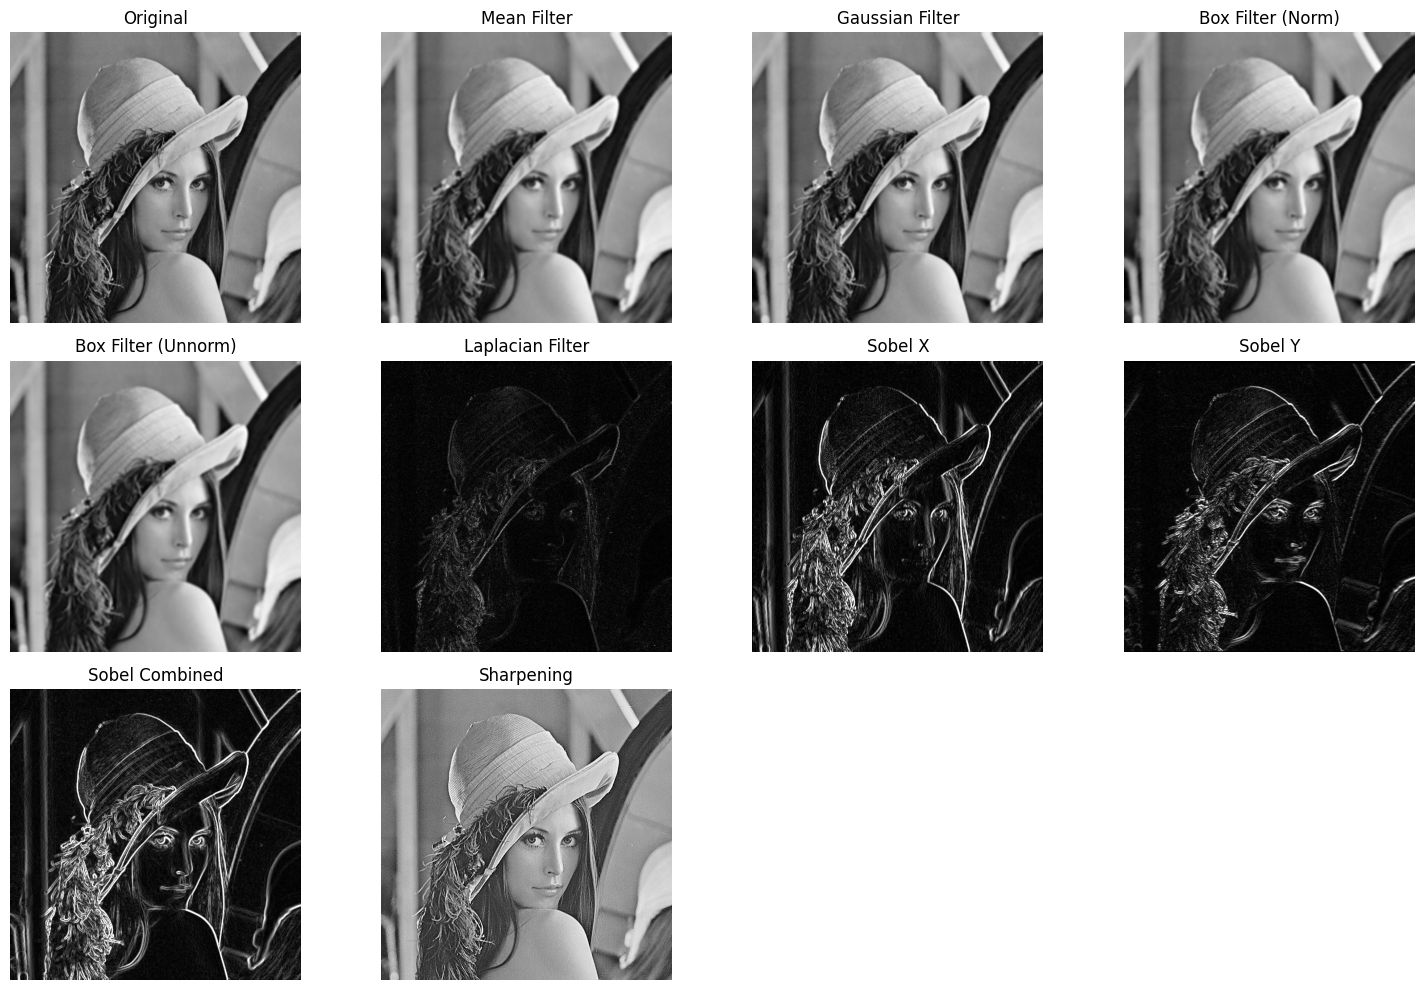

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (grayscale for spatial filtering)
image = cv2.imread('/content/drive/MyDrive/lena.png', cv2.IMREAD_GRAYSCALE)

# 1. Mean (Averaging) Filter
mean_filtered = cv2.blur(image, (5, 5))  # kernel size 5x5

# 2. Gaussian Filter
gaussian_filtered = cv2.GaussianBlur(image, (5, 5), 1)  # sigma=1

# 3. Box Filter (Unnormalized and Normalized)
box_normalized = cv2.boxFilter(image, -1, (5, 5), normalize=True)
# Convert to float32 to prevent overflow
image_float = image.astype(np.float32)

# Unnormalized box filter (sums values without dividing)
box_unnormalized_float = cv2.boxFilter(image_float, -1, (5, 5), normalize=False)

# Normalize for display
box_unnormalized_disp = cv2.normalize(box_unnormalized_float, None, 0, 255, cv2.NORM_MINMAX)
box_unnormalized_disp = box_unnormalized_disp.astype(np.uint8)



# 4. Laplacian Filter (Edge detection)
laplacian_filtered = cv2.Laplacian(image, cv2.CV_64F)
laplacian_filtered = cv2.convertScaleAbs(laplacian_filtered)  # convert back to uint8

# 5. Sobel Filter
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # X-direction
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Y-direction
sobel_combined = cv2.magnitude(sobel_x, sobel_y)
sobel_combined = cv2.convertScaleAbs(sobel_combined)

# 6. Sharpening Filter (Custom kernel)
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
sharpened = cv2.filter2D(image, -1, sharpen_kernel)

# ---- Plotting all results ----
plt.figure(figsize=(15, 10))

plt.subplot(3, 4, 1)
plt.imshow(image, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(mean_filtered, cmap='gray')
plt.title("Mean Filter")
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(gaussian_filtered, cmap='gray')
plt.title("Gaussian Filter")
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(box_normalized, cmap='gray')
plt.title("Box Filter (Norm)")
plt.axis('off')

plt.subplot(3, 4, 5)
plt.imshow(box_unnormalized_disp, cmap='gray')
plt.title("Box Filter (Unnorm)")
plt.axis('off')


plt.subplot(3, 4, 6)
plt.imshow(laplacian_filtered, cmap='gray')
plt.title("Laplacian Filter")
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(cv2.convertScaleAbs(sobel_x), cmap='gray')
plt.title("Sobel X")
plt.axis('off')

plt.subplot(3, 4, 8)
plt.imshow(cv2.convertScaleAbs(sobel_y), cmap='gray')
plt.title("Sobel Y")
plt.axis('off')

plt.subplot(3, 4, 9)
plt.imshow(sobel_combined, cmap='gray')
plt.title("Sobel Combined")
plt.axis('off')

plt.subplot(3, 4, 10)
plt.imshow(sharpened, cmap='gray')
plt.title("Sharpening")
plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
def save_averaging_kernel(size, path):
    if size % 2 == 0:
        raise ValueError("Kernel size must be an odd number.")

    value = round(1 / (size * size), 5)
    row = ' '.join([str(value)] * size)
    kernel_text = '\n'.join([row] * size)

    with open(path, 'w') as f:
        f.write(kernel_text)

    print(f"✅ {size}x{size} averaging kernel saved to {path}")


# Example usages:
save_averaging_kernel(3, '/content/kernel_3x3.txt')
save_averaging_kernel(7, '/content/kernel_7x7.txt')
save_averaging_kernel(11, '/content/kernel_11x11.txt')


✅ 3x3 averaging kernel saved to /content/kernel_3x3.txt
✅ 7x7 averaging kernel saved to /content/kernel_7x7.txt
✅ 11x11 averaging kernel saved to /content/kernel_11x11.txt


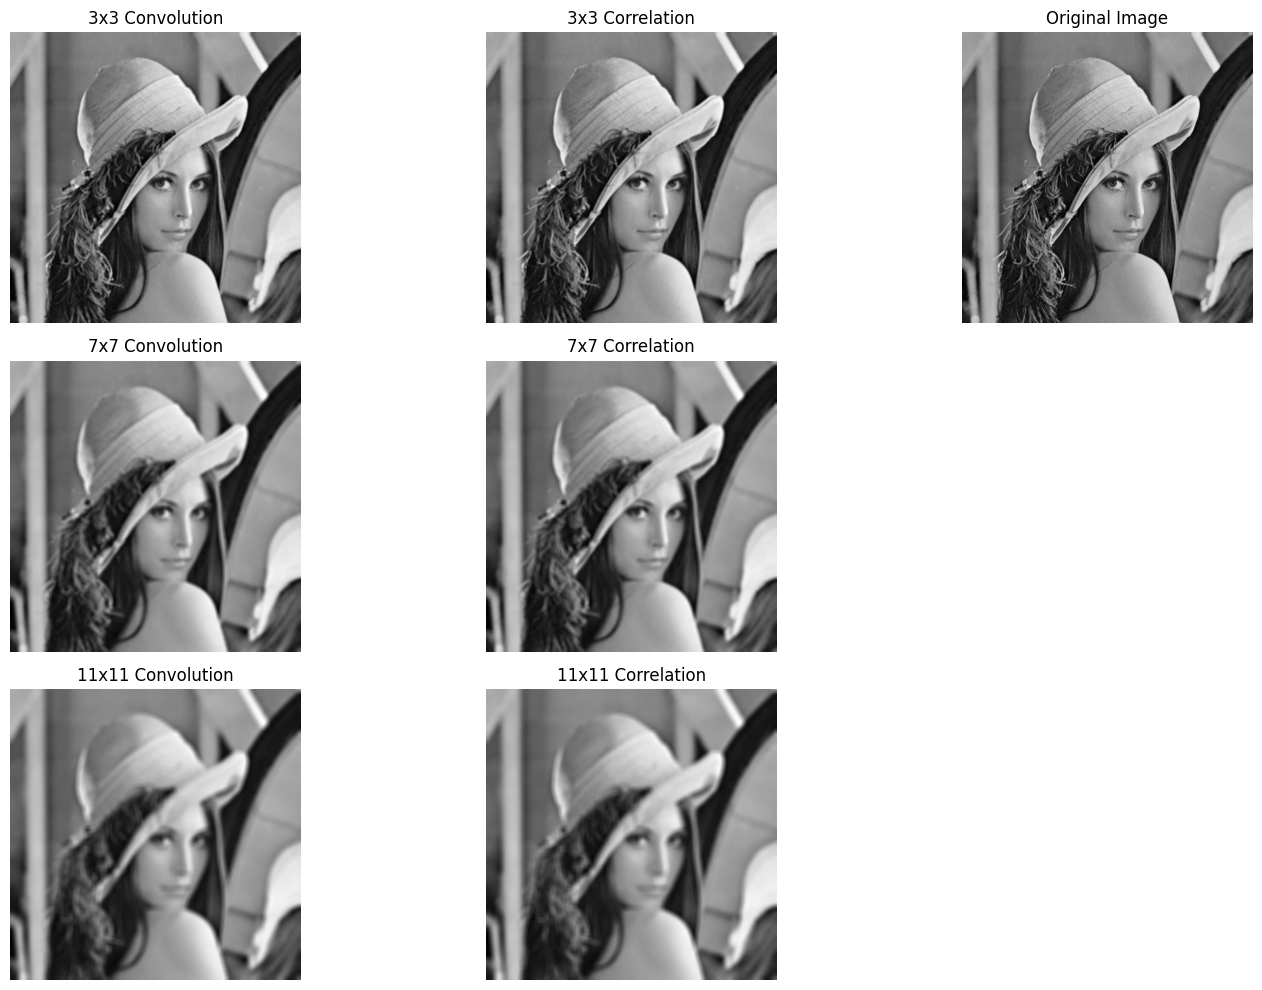

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_kernel_from_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        kernel = [list(map(float, line.strip().split())) for line in lines]
    return np.array(kernel)

def apply_convolution(image, kernel):
    return cv2.filter2D(image, -1, kernel)

def apply_correlation(image, kernel):
    flipped_kernel = cv2.flip(kernel, -1)  # Flip both axes for correlation
    return cv2.filter2D(image, -1, flipped_kernel)

# Load image (grayscale)
image = cv2.imread('/content/drive/MyDrive/lena.png', cv2.IMREAD_GRAYSCALE)

# Load different kernels
kernel_3x3 = load_kernel_from_file('/content/kernel_3x3.txt')
kernel_7x7 = load_kernel_from_file('/content/kernel_7x7.txt')
kernel_11x11 = load_kernel_from_file('/content/kernel_11x11.txt')

# Apply convolution and correlation
def process(image, kernel):
    conv = apply_convolution(image, kernel)
    corr = apply_correlation(image, kernel)
    return conv, corr

conv3, corr3 = process(image, kernel_3x3)
conv7, corr7 = process(image, kernel_7x7)
conv11, corr11 = process(image, kernel_11x11)

# Display results
plt.figure(figsize=(15, 10))

plt.subplot(3, 3, 1)
plt.imshow(conv3, cmap='gray')
plt.title('3x3 Convolution')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(corr3, cmap='gray')
plt.title('3x3 Correlation')
plt.axis('off')

plt.subplot(3, 3, 4)
plt.imshow(conv7, cmap='gray')
plt.title('7x7 Convolution')
plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(corr7, cmap='gray')
plt.title('7x7 Correlation')
plt.axis('off')

plt.subplot(3, 3, 7)
plt.imshow(conv11, cmap='gray')
plt.title('11x11 Convolution')
plt.axis('off')

plt.subplot(3, 3, 8)
plt.imshow(corr11, cmap='gray')
plt.title('11x11 Correlation')
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.tight_layout()
plt.show()
